In [23]:
!pip install HDBSCAN
!pip install h3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from geopy.distance import great_circle
import folium
import geopandas as gpd
from sklearn.cluster import SpectralClustering
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import time
from hdbscan import HDBSCAN
from folium.plugins import MarkerCluster
from sklearn.metrics import silhouette_score, davies_bouldin_score
import random
import h3
from folium import plugins

ModuleNotFoundError: No module named 'hdbscan'

In [31]:
data = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/train.csv')

data = data.drop(columns = ['fare_amount','key','passenger_count'])
df = data[:10*1000]

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']) 

df = df.rename(columns={"pickup_datetime": "timestamp", "pickup_longitude": "first_longitude", "pickup_latitude": "first_latitude", "dropoff_longitude": "second_longitude", "dropoff_latitude": "second_latitude"})

/tmp/ipykernel_30/4172816561.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])


In [124]:
ts = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv')
ts = ts[['date', 'meantemp']]
ts['date'] = pd.to_datetime(ts['date']) 
ts = ts.rename(columns={"date": "timestamp", "meantemp": "target"})

In [10]:
df.head()

,timestamp,first_longitude,first_latitude,second_longitude,second_latitude
0,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278
1,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004
2,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562
3,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092
4,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762


In [46]:
ts.head()

,timestamp,target
0,2013-01-01,10.000000
1,2013-01-02,7.400000
2,2013-01-03,7.166667
3,2013-01-04,8.666667
4,2013-01-05,6.000000


# **Creating data features**

**1. Базовые признаки даты и времени**

Год (Year): Может быть полезным, если данные охватывают несколько лет и в них есть тенденции или изменения со временем. Месяц (Month): Часто используется в задачах с сезонностью, например, в продажах, туризме и т. д.

День месяца (Day): Полезен в задачах, связанных с конкретными днями месяца, например, в периодах высокой нагрузки (в начале и конце месяца).

День недели (Day of Week): Применяется, когда поведение зависит от дня недели, например, различия между выходными и будними днями.

Час (Hour): Суточные колебания важны в таких задачах, как анализ спроса, посещаемости, активности пользователей и т. д.

Минута и секунда (Minute, Second): Обычно используются для высокочастотных данных, когда важен временной интервал в пределах часа (например, в финансовых или IoT-данных).

In [11]:
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour

**2. Бинарные признаки**

Эти признаки показывают, принадлежит ли временная метка определенной категории:

Признак выходного дня (Is Weekend): Бинарный признак, указывающий, является ли день выходным (суббота или воскресенье).

Признак праздника (Is Holiday): Может указывать, приходится ли дата на праздничный день. Данные о праздниках могут быть загружены для конкретной страны или региона.

Час пик (Is Rush Hour): Может быть полезен в транспортных данных или в задачах, связанных с пиковыми периодами нагрузки (утро и вечер в будни).

In [26]:
def is_weekend(day):
    if day == 6 or day == 7:
        return 1
    else:
        return 0
df['is_weekend'] = df['day_of_week'].apply(lambda day: is_weekend(day))

# РУССКИЕ ПРАЗДНИКИ
holidays = [
    [1, 1],   # 1 января — Новогодние каникулы
    [1, 2],   # 2 января — Новогодние каникулы
    [1, 3],   # 3 января — Новогодние каникулы
    [1, 4],   # 4 января — Новогодние каникулы
    [1, 5],   # 5 января — Новогодние каникулы
    [1, 6],   # 6 января — Новогодние каникулы
    [1, 8],   # 8 января — Новогодние каникулы
    [1, 7],   # 7 января — Рождество Христово
    [2, 23],  # 23 февраля — День защитника Отечества
    [3, 8],   # 8 марта — Международный женский день
    [5, 1],   # 1 мая — Праздник Весны и Труда
    [5, 9],   # 9 мая — День Победы
    [6, 12],  # 12 июня — День России
    [11, 4]   # 4 ноября — День народного единства
]

def is_holiday(data_):
    month_trg, day_trg = data_['month'], data_['day']
    for month, day in holidays:
        if month == month_trg and day == day_trg:
            return 1
    return 0

df['is_holiday'] = df[['month', 'day']].apply(is_holiday, axis=1)

def is_rush_hour(row):
    if row['day_of_week'] < 5 and (7 <= row['hour'] <= 10 or 17 <= row['hour'] <= 20) and row['is_holiday'] == 0:
        return 1
    else:
        return 0

df['is_rush_hour'] = df.apply(is_rush_hour, axis=1)

**3. Сезонные признаки**

Сезон (Season): Признак, указывающий сезон (зима, весна, лето, осень). Особенно полезен в задачах с погодой или данными о сельском хозяйстве.

Квартал года (Quarter): Годовой квартал (1, 2, 3 или 4), что может быть полезно в данных, где квартальные отчеты или циклы важны, например, в финансовом секторе.

In [30]:
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Зима
    elif month in [3, 4, 5]:
        return 1  # Весна
    elif month in [6, 7, 8]:
        return 2  # Лето
    else:
        return 3  # Осень

df['season'] = df['month'].apply(lambda x: get_season(x))

df['quarter'] = df['timestamp'].dt.quarter

**4. Циклические признаки**

Некоторые признаки (например, день недели, месяц, час) имеют циклический характер. Для их корректного представления можно использовать синус и косинус, чтобы модель правильно учитывала цикличность.

Признаки синус и косинус: Это преобразование важно, поскольку, например, за 23:00 идет 0:00, и разница между ними по циклу должна быть минимальной.

In [34]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

**5. Признаки временного интервала**

Прошло времени с начала (Time Since Start): Показывает, сколько времени прошло с начала определенного периода. Например, сколько дней прошло с начала года.

Прошло времени с последнего события (Time Since Last Event): Важно в задачах, где нужно учитывать, когда произошло предыдущее событие. Например, как давно клиент посещал магазин.

In [56]:
# ts['days_since_start_of_year'] = (ts['timestamp'] - pd.to_datetime(ts['timestamp'].dt.year.astype(str) + '-01-01')).dt.days


# ts['days_since_last_visit'] = ts.sort_values(['days_since_start_of_year', 'timestamp']).groupby('days_since_start_of_year')['timestamp'].diff().dt.days
# ts = ts.fillna(0)

**6. Скользящие и агрегированные статистики**

На основе временных меток можно создать статистику по предыдущим или будущим периодам, особенно полезную в задачах прогнозирования:

Среднее значение за период (Rolling Mean): Среднее значение целевой переменной за последние n дней или часов.

Сумма за период (Rolling Sum): Сумма значений целевой переменной за определенный временной промежуток.

Максимум и минимум за последние n дней или часов. Эти признаки используются для сглаживания данных и выявления общих тенденций.

In [61]:
ts = ts.sort_values(by='timestamp')

window = 3

ts['rolling_mean'] = ts['target'].rolling(window=window).mean()
ts['rolling_sum'] = ts['target'].rolling(window=window).sum()
ts['rolling_max'] = ts['target'].rolling(window=window).max()
ts['rolling_min'] = ts['target'].rolling(window=window).min()

**7. Тренд и сезонность**

Если у вас есть временные ряды, можно извлечь компоненты тренда и сезонности. Эти признаки особенно важны для задач прогнозирования временных рядов. Компоненты тренда и сезонности могут быть выделены с помощью таких методов, как декомпозиция STL (Seasonal-Trend decomposition using Loess).

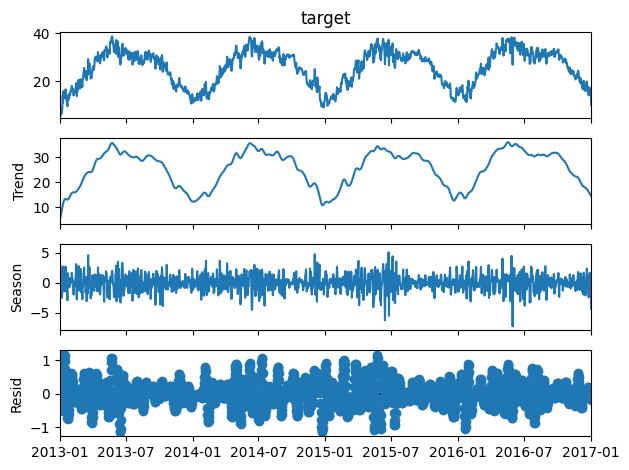

In [125]:
ts.set_index('timestamp', inplace=True)

seasonal_period = 3 # меняется конкретно под задачу 

result = STL(ts['target'], seasonal=seasonal_period).fit()

result.plot()
plt.show()

ts['trend'] = result.trend
ts['seasonal'] = result.seasonal
ts['residual'] = result.resid

ts = ts.reset_index()

**8. Показатель активности**

События в течение определенного периода: Подсчет количества событий за определенные периоды. Например, количество покупок пользователя за последнюю неделю.

Среднее время между событиями: Например, среднее время между посещениями пользователя. Это помогает понять частоту взаимодействия.

In [ ]:
ts = ts.sort_values(by=['user_id', 'timestamp'])

# Подсчитываем количество событий за последние 7 дней для каждого события
ts['events_in_last_7_days'] = ts.groupby('user_id')['timestamp'].apply(lambda x: x.rolling('7D', on='timestamp').count())

# Вычисляем время между событиями для каждого пользователя
ts['time_between_events'] = ts.groupby('user_id')['timestamp'].diff()

# Среднее время между событиями для каждого пользователя
ts['avg_time_between_events'] = ts.groupby('user_id')['time_between_events'].transform('mean')

**Дополнительно**

In [117]:
interval_length = 3

result_data = {col: [] for col in df.columns if col != 'timestamp'}

for start in range(len(df)-interval_length, -1, -interval_length):
    end = start + interval_length
    subset = df.iloc[start:end]
    
    for col in result_data.keys():
        result_data[col].append(subset[col].tolist())

aggregated_data = {}

for column, values in result_data.items():
    for i in range(interval_length):
        aggregated_data[f'{column}_{i+1}'] = [x[i] if len(x) > i else None for x in values]

aggregated_df = pd.DataFrame(aggregated_data)
aggregated_df_reversed = aggregated_df.iloc[::-1].reset_index(drop=True)
# Выводим результат
print(aggregated_df_reversed)

      target_1   target_2   target_3    trend_1    trend_2    trend_3  \
0     7.400000   7.166667   8.666667   7.364887   7.618856   7.910650   
1     6.000000   7.000000   7.000000   8.234800   8.592028   9.103575   
2     8.857143  14.000000  11.000000  10.057417  11.117980  12.167558   
3    15.714286  14.000000  15.833333  13.055929  13.714234  14.165709   
4    12.833333  14.714286  13.833333  14.400789  14.409503  14.153577   
..         ...        ...        ...        ...        ...        ...   
482  16.083333  17.857143  19.800000  17.583200  17.510578  17.433439   
483  18.050000  17.285714  15.550000  17.322386  17.151358  16.936006   
484  17.318182  14.000000  17.142857  16.694624  16.439040  16.190721   
485  16.850000  17.217391  15.238095  15.807986  15.327063  14.837474   
486  14.095238  15.052632  10.000000  14.335895  13.813105  13.259885   

     seasonal_1  seasonal_2  seasonal_3  residual_1  residual_2  residual_3  
0      0.753748    0.814581    0.908027   -0.

# **Geo data**

**1. Признаки расстояния**

Расстояние до определенных точек:

Рассчитать расстояние от каждой точки до известных местоположений, таких как центр города, ближайший аэропорт или место конкурентов. Это можно сделать с помощью формулы Харверсина или встроенных функций библиотек (например, GeoPy).

Расстояние между точками: Если объекты распределены по географии (например, магазины, офисы), можно рассчитать расстояние между ними, чтобы выявить кластеры и зоны высокой плотности.

In [9]:
def calculate_distance(lat1, lon1, lat2, lon2):
    point1 = (lat1, lon1)
    point2 = (lat2, lon2)
    
    distance = great_circle(point1, point2).kilometers
    return distance

moscow_center = (55.751244, 37.618423)

df['distance_to_moscow_center'] = df[['first_latitude', 'first_longitude']].apply(lambda row: calculate_distance(*row, *moscow_center), axis=1)

df['distance'] = df[['first_latitude', 'first_longitude', 'second_latitude', 'second_longitude']].apply(lambda row: calculate_distance(*row), axis=1)

In [10]:
df

,timestamp,first_longitude,first_latitude,second_longitude,second_latitude,distance_to_moscow_center,distance
0,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,14380.724647,0.412061
1,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,14399.864493,4.646229
2,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,14396.211140,1.004797
3,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,14396.666247,0.914154
4,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,14394.586547,1.366164
...,...,...,...,...,...,...,...
9995,2011-10-26 10:44:00+00:00,-73.988277,40.748970,-73.963712,40.773958,14396.813634,2.847789
9996,2011-12-16 15:37:00+00:00,-74.002112,40.748727,-73.992467,40.756252,14398.356195,1.101105
9997,2013-11-16 22:47:17+00:00,-73.992093,40.729071,-73.974470,40.763050,14397.214724,2.228136
9998,2010-01-28 11:38:00+00:00,-73.992548,40.735652,-73.998802,40.723085,14397.273539,0.798057


**2. Кластеризация с помощью координат**

Кластеризация методом K-средних: Применение алгоритма KMeans к широте и долготе позволяет разделить объекты на кластеры, представляющие географические регионы. Результат будет особенно полезен для создания категорий по расположению.

DBSCAN: Подходит для выявления плотных кластеров в данных. Например, можно найти группы точек (точки интереса, магазины) в зонах высокой плотности и добавить в модель признак принадлежности к кластеру.

In [39]:
coordinates = df[['first_latitude', 'first_longitude']].values

# Задаем диапазоны для перебора параметров
n_clusters_range = range(2, 10)  # Количество кластеров от 2 до 5
n_neighbors_range = range(5, 11)  # Количество соседей от 5 до 10

best_score = -1
best_params = {}

for n_clusters in n_clusters_range:
    for n_neighbors in n_neighbors_range:
        clustering = SpectralClustering(
            n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=n_neighbors, random_state=42
        )
        try:
            # Проводим кластеризацию
            labels = clustering.fit_predict(coordinates)
            
            # Оцениваем качество кластеризации
            silhouette_avg = silhouette_score(coordinates, labels)
            davies_bouldin = davies_bouldin_score(coordinates, labels)

            print(f"n_clusters={n_clusters}, n_neighbors={n_neighbors}, Silhouette Score={silhouette_avg:.4f}, Davies-Bouldin={davies_bouldin:.4f}")

            # Ищем лучший результат
            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_params = {'n_clusters': n_clusters, 'n_neighbors': n_neighbors}

        except Exception as e:
            # Игнорируем комбинации, для которых кластеризация не удалась
            print(f"Failed for n_clusters={n_clusters}, n_neighbors={n_neighbors} due to error: {e}")

print(f"\nЛучшие параметры: {best_params} с Silhouette Score={best_score:.4f}")

n_clusters=2, n_neighbors=5, Silhouette Score=0.1059, Davies-Bouldin=1.7497
n_clusters=2, n_neighbors=6, Silhouette Score=0.1460, Davies-Bouldin=1.7389
n_clusters=2, n_neighbors=7, Silhouette Score=-0.0542, Davies-Bouldin=1.7854
n_clusters=2, n_neighbors=8, Silhouette Score=-0.0142, Davies-Bouldin=1.7774
n_clusters=2, n_neighbors=9, Silhouette Score=-0.0942, Davies-Bouldin=1.7927
n_clusters=2, n_neighbors=10, Silhouette Score=-0.1341, Davies-Bouldin=1.7996
n_clusters=3, n_neighbors=5, Silhouette Score=0.1403, Davies-Bouldin=1.3984
n_clusters=3, n_neighbors=6, Silhouette Score=-0.0044, Davies-Bouldin=1.5979
n_clusters=3, n_neighbors=7, Silhouette Score=-0.0212, Davies-Bouldin=1.6231
n_clusters=3, n_neighbors=8, Silhouette Score=0.0487, Davies-Bouldin=1.5696
n_clusters=3, n_neighbors=9, Silhouette Score=0.0121, Davies-Bouldin=1.5982
n_clusters=3, n_neighbors=10, Silhouette Score=-0.0676, Davies-Bouldin=1.6822
n_clusters=4, n_neighbors=5, Silhouette Score=0.1448, Davies-Bouldin=1.3982
n_c

In [68]:
colors = [
    'red', 'blue', 'green', 'purple', 'orange', 'pink', 'lightblue', 'yellow',
    'brown', 'darkgreen', 'darkblue', 'cyan', 'violet', 'darkred', 'indigo',
    'lightgreen', 'beige', 'gray', 'gold', 'navy'
]

# Кластеризация начальных точек
coordinates = df[['first_latitude', 'first_longitude']].values
clustering = SpectralClustering(n_clusters=8, affinity='nearest_neighbors', n_neighbors=6, random_state=42)
labels = clustering.fit_predict(coordinates)

# Добавляем метки кластеров в DataFrame
df['cluster_SpectralClustering'] = labels

map_center = [40.721319, -73.841610]  
mymap = folium.Map(location=map_center, zoom_start=10)

# Создаем кластер для маркеров
marker_cluster = MarkerCluster().add_to(mymap)

# Добавляем маркеры для каждой точки начала с кластеризацией
for idx, row in df.iterrows():
    cluster_id = row['cluster_SpectralClustering']
    
    # Присваиваем цвет по кластеру
    color = colors[cluster_id % len(colors)]
    
    folium.Marker(
        location=[row['first_latitude'], row['first_longitude']],
        popup=f"Cluster {cluster_id + 1}",
        icon=folium.Icon(color=color, icon="info-sign")
    ).add_to(marker_cluster)



# Отображение карты
mymap

/tmp/ipykernel_30/1782359048.py:31: UserWarning: color argument of Icon should be one of: {'pink', 'darkpurple', 'blue', 'lightblue', 'green', 'gray', 'lightgray', 'red', 'beige', 'lightgreen', 'darkred', 'darkblue', 'purple', 'orange', 'cadetblue', 'darkgreen', 'black', 'white', 'lightred'}.
  icon=folium.Icon(color=color, icon="info-sign")


In [66]:
colors = [
    'red', 'blue', 'green', 'purple', 'orange', 'pink', 'lightblue', 'yellow',
    'brown', 'darkgreen', 'darkblue', 'cyan', 'violet', 'darkred', 'indigo',
    'lightgreen', 'beige', 'gray', 'gold', 'navy'
]

coordinates = df[['first_latitude', 'first_longitude']].values

# Кластеризация с помощью HDBSCAN
clusterer = HDBSCAN(min_cluster_size=4, min_samples=1)
labels = clusterer.fit_predict(coordinates)

# Добавляем метки кластеров в DataFrame
df['cluster_HDBSCAN'] = labels


map_center = [40.721319, -73.841610]  
mymap = folium.Map(location=map_center, zoom_start=10)

# Создаем кластер для маркеров
marker_cluster = MarkerCluster().add_to(mymap)

# Добавляем маркеры для каждой точки начала с кластеризацией
for idx, row in df.iterrows():
    cluster_id = row['cluster_HDBSCAN']
    
    # Определяем цвет маркера по кластеру
    if cluster_id == -1:
        # Это шумовые точки
        color = 'gray'
    else:
        # Применяем различные цвета для разных кластеров
        color = ['red', 'blue', 'green', 'purple', 'orange'][cluster_id % 5]
    
    folium.Marker(
        location=[row['first_latitude'], row['first_longitude']],
        popup=f"Cluster {cluster_id if cluster_id != -1 else 'Noise'}",
        icon=folium.Icon(color=color, icon="info-sign")
    ).add_to(marker_cluster)

# Отображение карты
mymap

**3. Признаки сетки (grid features)**

Квадратная сетка: Разделение всей территории на ячейки фиксированного размера (например, 0.1° × 0.1°). Каждой точке присваивается категория, соответствующая ее ячейке. Такой метод позволяет легко учитывать региональные различия в модели.

Географическая сетка H3: H3 – это геокодировочная система, которая делит Землю на шестиугольники разного размера. Этот метод удобен для создания признаков на основе принадлежности точки к определенной ячейке и учитывает географические расстояния.

In [57]:
def take_h3_indx(lat, long, size):
    h3_address = h3.latlng_to_cell(lat, long,  size)      
    return h3_address

size = 11
df['h3_first_indx_small'] = df[['first_longitude', 'first_latitude']].apply(lambda row: take_h3_indx(*row, size), axis = 1)  
df['h3_second_indx_small'] = df[['second_longitude', 'second_latitude']].apply(lambda row: take_h3_indx(*row, size), axis = 1)  

size = 9
df['h3_first_indx'] = df[['first_longitude', 'first_latitude']].apply(lambda row: take_h3_indx(*row, size), axis = 1)  
df['h3_second_indx'] = df[['second_longitude', 'second_latitude']].apply(lambda row: take_h3_indx(*row, size), axis = 1)  

size = 7
df['h3_first_indx_large'] = df[['first_longitude', 'first_latitude']].apply(lambda row: take_h3_indx(*row, size), axis = 1)  
df['h3_second_indx_large'] = df[['second_longitude', 'second_latitude']].apply(lambda row: take_h3_indx(*row, size), axis = 1) 

size = 5
df['h3_first_indx_exlarge'] = df[['first_longitude', 'first_latitude']].apply(lambda row: take_h3_indx(*row, size), axis = 1)  
df['h3_second_indx_exlarge'] = df[['second_longitude', 'second_latitude']].apply(lambda row: take_h3_indx(*row, size), axis = 1) 

**4. Признаки на основе расстояния и направления**

Азимут (угол направления): Если важно направление от одной точки к другой, можно вычислить азимут — угол направления относительно северного полюса. Этот признак может помочь, например, в анализе маршрутов.

Векторные признаки: Широту и долготу можно разложить на синус и косинус для создания векторных признаков. Это полезно для задач, где важно направление, особенно при анализе дорожных данных.

In [ ]:
def calculate_bearing(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
 
    dlon = lon2_rad - lon1_rad
 
    y = math.sin(dlon) * math.cos(lat2_rad)
    x = math.cos(lat1_rad) * math.sin(lat2_rad) - \
        math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(dlon)
 
    bearing_rad = math.atan2(y, x)
    bearing_deg = math.degrees(bearing_rad)
 
    # Normalize to [0, 360) degrees
    bearing_deg = (bearing_deg + 360) % 360
 
    return bearing_deg


df['bearing_deg'] = df[['first_latitude', 'first_longitude', 'second_latitude', 'second_longitude']].apply(lambda row: calculate_bearing(*row), axis=1)


def lat_lng_to_vector(latitude, longitude):
    """
    Преобразует широту и долготу в трехмерные координаты на единичной сфере.
    Входные данные: широта и долгота в градусах.
    """
    # Переводим градусы в радианы
    lat_rad = np.radians(latitude)
    lng_rad = np.radians(longitude)
    
    # Вычисляем x, y, z координаты
    x = np.cos(lat_rad) * np.cos(lng_rad)
    y = np.cos(lat_rad) * np.sin(lng_rad)
    z = np.sin(lat_rad)
    
    return np.array([x, y, z])

df[['first_x', 'first_y', 'first_z']] = df.apply(
    lambda row: lat_lng_to_vector(row['first_latitude'], row['first_longitude']), axis=1, result_type='expand'
)
df[['second_x', 'second_y', 'second_z']] = df.apply(
    lambda row: lat_lng_to_vector(row['second_latitude'], row['second_longitude']), axis=1, result_type='expand'
)


def lat_lng_to_fourier_features(latitude, longitude):
    """
    Преобразует широту и долготу в Fourier-признаки.
    Входные данные: широта и долгота в градусах.
    """
    # Переводим градусы в радианы
    lat_rad = np.radians(latitude)
    lng_rad = np.radians(longitude)
    
    # Вычисляем sin и cos для широты и долготы
    lat_sin = np.sin(lat_rad)
    lat_cos = np.cos(lat_rad)
    lng_sin = np.sin(lng_rad)
    lng_cos = np.cos(lng_rad)
    
    return np.array([lat_sin, lat_cos, lng_sin, lng_cos])

df[['first_lat_sin', 'first_lat_cos', 'first_lng_sin', 'first_lng_cos']] = df.apply(
    lambda row: lat_lng_to_fourier_features(row['first_latitude'], row['first_longitude']), axis=1, result_type='expand'
)

# Применяем функцию для второго набора координат
df[['second_lat_sin', 'second_lat_cos', 'second_lng_sin', 'second_lng_cos']] = df.apply(
    lambda row: lat_lng_to_fourier_features(row['second_latitude'], row['second_longitude']), axis=1, result_type='expand'
)


**6. Региональные признаки**

Кодирование адресов и административных границ: Преобразование широты и долготы в почтовые индексы, районы или другие административные зоны. Примером может быть использование обратного геокодирования для получения региона или типа зоны (жилой район, коммерческая зона).

Социально-демографические признаки региона: Можно дополнительно загрузить статистические данные для районов (доходы, население, инфраструктура) и присвоить эти данные точкам в зависимости от их местоположения.

**Дополнительно**

In [69]:
import folium
import geopandas as gpd
import numpy as np
from sklearn.cluster import SpectralClustering
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import time
from folium.plugins import MarkerCluster
geolocator = Nominatim(user_agent="kaggle_learn")


cities = [
    "Москва", "Санкт-Петербург", "Новосибирск", "Екатеринбург", "Казань", "Нижний Новгород",
    "Самара", "Уфа", "Челябинск", "Омск", "Ростов-на-Дону", "Волгоград", "Красноярск", "Пермь"
]

def get_coordinates(city):
    try:
        location = geolocator.geocode(city + ", Россия", exactly_one=True)
        if location:
            return location.latitude, location.longitude
        else:
            print(f"Город {city} не найден.")
            return None
    except Exception as e:
        print(f"Ошибка при геокодировании {city}: {e}")
        return None

# Получаем координаты всех городов
coordinates = []
valid_cities = []
for city in cities:
    coords = get_coordinates(city)
    if coords:
        coordinates.append(coords)
        valid_cities.append(city)
    time.sleep(0.2)  # Задержка, чтобы избежать перегрузки запросов к серверу


if not coordinates:
    print("Не удалось получить координаты для городов.")
else:
    print(f"Полученные координаты для {len(coordinates)} городов.")

geometry = [Point(lon, lat) for lat, lon in coordinates]
gdf = gpd.GeoDataFrame(valid_cities, geometry=geometry, columns=["City"])

# Кластеризация с использованием SpectralClustering
clustering = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_neighbors=5, random_state=42)
labels = clustering.fit_predict(coordinates)

# Добавляем метки кластеров в GeoDataFrame
gdf['cluster'] = labels

# Создаем карту с начальной точкой (например, центр России)
map_center = [55.7558, 37.6173]  # Москва
mymap = folium.Map(location=map_center, zoom_start=5)

# Создаем кластер для маркеров
marker_cluster = MarkerCluster().add_to(mymap)

# Добавляем маркеры с результатами кластеризации в кластер
for idx, row in gdf.iterrows():
    folium.Marker(
        location=[row['geometry'].y, row['geometry'].x],  # latitude, longitude
        popup=f"{row['City']} (Cluster {row['cluster'] + 1})",
        icon=folium.Icon(color=['red', 'green', 'blue'][row['cluster']], icon="info-sign")
    ).add_to(marker_cluster)

mymap

Полученные координаты для 14 городов.
